## Brazilian e-commerce dataset by Olist

### Import all stuff

In [305]:
from collections import defaultdict
from functools import partial
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# %matplotlib inline

### Load the data

In [306]:
# Dataset:
# https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
DATASET_DIR = '../../olist_ecommerce_dataset/'
# customer_unique_id not needed (it's interchangeable with order id)
# order_item_id not needed

o_customers = pd.read_csv(f'{DATASET_DIR}olist_customers_dataset.csv')
print(o_customers.columns)
# o_geolocation = pd.read_csv(f'{DATASET_DIR}olist_geolocation_dataset.csv')
# print(o_geolocation.columns)
# order_item_id not needed
o_order_items = pd.read_csv(f'{DATASET_DIR}olist_order_items_dataset.csv')
print(o_order_items.columns)
# o_order_payments = pd.read_csv(f'{DATASET_DIR}olist_order_payments_dataset.csv')
# print(o_order_payments.columns)
# o_order_reviews = pd.read_csv(f'{DATASET_DIR}olist_order_reviews_dataset.csv')
# print(o_order_reviews.columns)
o_customers = pd.read_csv(f'{DATASET_DIR}olist_customers_dataset.csv')
print(o_customers.columns)
# o_category_name_translations = pd.read_csv(f'{DATASET_DIR}product_category_name_translation.csv')
# print(o_category_name_translations.columns)
o_sellers = pd.read_csv(f'{DATASET_DIR}olist_sellers_dataset.csv')
print(o_sellers.columns)
o_products = pd.read_csv(f'{DATASET_DIR}olist_products_dataset.csv')
print(o_products.columns)
o_orders = pd.read_csv(f'{DATASET_DIR}olist_orders_dataset.csv')
print(o_orders.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


### Utility functions

In [274]:
def is_k_anonymous(k, qis, df):
    """Returns true if df satisfies k-Anonymity for the quasi-identifiers 
    qis. Returns false otherwise."""
    group_sizes = df.groupby(qis).size()
    for group_size in group_sizes:
        if group_size < k:
            return False
    return True

def laplace_mech(v, sensitivity, epsilon):
    b = sensitivity/epsilon

    # location = mu + v = v for DP
    # scale = b
    return np.random.laplace(v, b)

def dp_noisy_clipped_sum(arr, epsilon):
    # Since our goal is to be reasonably accurate with larger datasets, we
    # use up only small amount of privacy budget for this.
    noisy_total_line_count = laplace_mech(len(arr), 1, 0.1 * epsilon)
    epsilon *= 0.9
    cap = 0
    c = 100
    for _ in range(20):
        # get noisy count of lines that fall under the current clip threshold
        count = sum(v <= c for v in arr)
        noisy_count = laplace_mech(count, 1, 0.1 * epsilon)
        epsilon *= 0.8
        if noisy_count >= 0.9 * noisy_total_line_count:
            cap = c
            break;
        c *= 5

    s = sum(min(v, cap) for v in arr)
    # Clipping parameter is the same as sensitivity.
    # Because that't the largest single value possible.
    return laplace_mech(s, cap, epsilon) #remaining_privacy_budget)

def histogram(df_columns, title, xlabel, ylabel="Number of occurences", bins=50):
    df_columns.hist(bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Number of occurences')
    plt.yscale("log")
    plt.show()

def clip_col(df_col, clip_val):
    return df_col.apply(lambda v: min(v, clip_val))

def buckets(df_col, bucket_size):
    return df_col.apply(lambda v: int(int(v) / bucket_size + 1))

def clip_buckets(df_col, clip_val, bucket_size, clip_low=0):
    return df_col.apply(lambda v: int(int(min(max(v, clip_low), clip_val)) / bucket_size + 1))

In [244]:
# Section 5 (income of sellers)

# Query sys, needs fixing dp_sum_capgain

# Get noisy incomes of all sellers
# plot diff noisy to real sum
# privacy unit: item sale
sellers_item_prices = defaultdict(list)
o_order_items.apply(lambda v: sellers_item_prices[v.seller_id].append(v.price), axis=1)
# print(sellers_item_prices)

# Calculate noisy sums; privacy unit: item purchase
# For each seller, get the true sum and the noisy sum. Will plot their diff.
epsilon = 1
diff_percents = [[], [], [], [], [], [], [], [], [], [], [], []]
vals = list(sellers_item_prices.values())
for i in range(12):
    for item_prices in vals:
        true_sum = sum(item_prices)
        noisy_sum = dp_noisy_clipped_sum(item_prices, epsilon=epsilon)
        diff_percents[i].append(abs(((true_sum - noisy_sum)/true_sum) * 100))
    epsilon *= 2

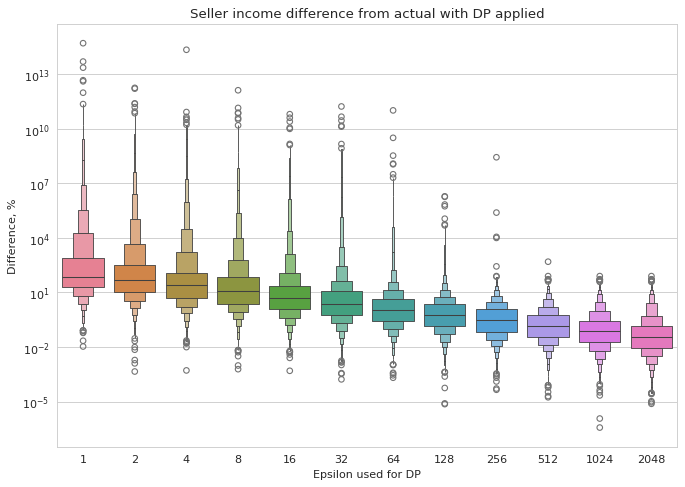

In [327]:
from matplotlib.pyplot import figure

figure(figsize=(10, 7), dpi=80)

g = sns.boxenplot(diff_percents)
g.set_xticks(range(len(diff_percents)))
g.set_xticklabels([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])
plt.yscale("log")
plt.title("Seller income difference from actual with DP applied")
plt.ylabel("Difference, %")
plt.xlabel("Epsilon used for DP")
plt.show()

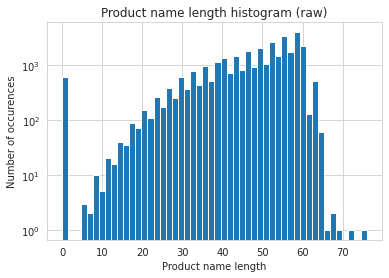

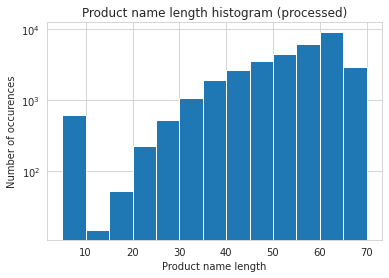

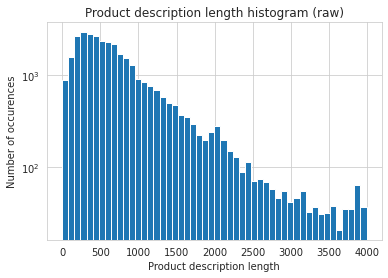

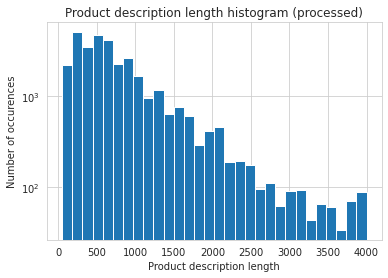

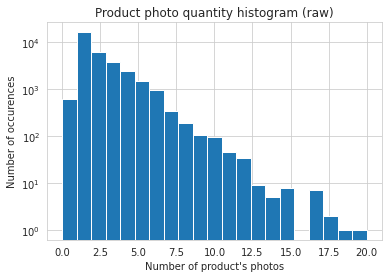

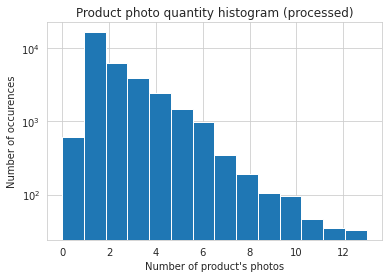

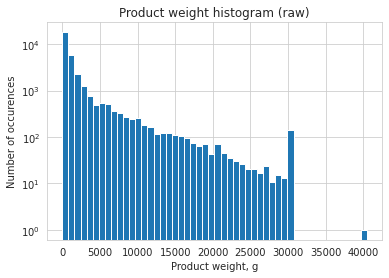

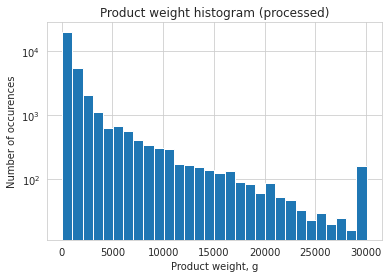

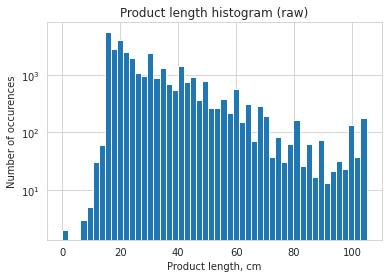

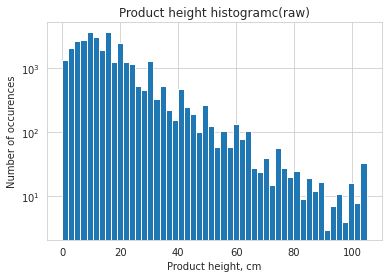

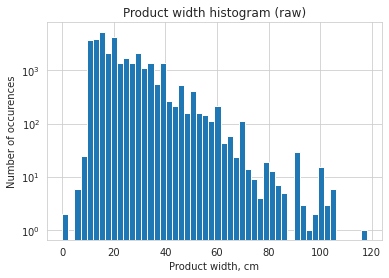

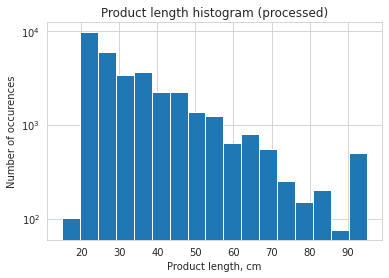

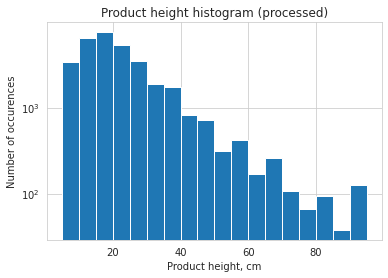

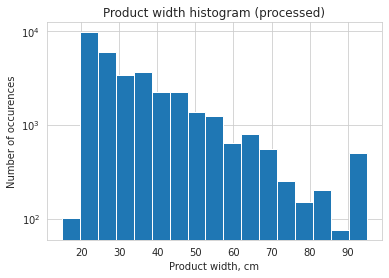

In [328]:
# Section 7 (product characteristics)
o_products_proc = pd.DataFrame()

# Replace NaNs with 0s
o_products.fillna(0, inplace=True)
# Note that NaNs replaced with 0s


histogram(o_products[["product_name_lenght"]], "Product name length histogram (raw)", xlabel="Product name length")

# Product name length
# Rounding/bucketization/generalization
# Clip at 65.
# Use buckets. Bucket size 5.
processed_product_name_lengths = clip_buckets(o_products["product_name_lenght"], 65, 5)
o_products_proc.insert(0, "product_name_length", processed_product_name_lengths)
histogram(o_products_proc[["product_name_length"]] * 5, "Product name length histogram (processed)", xlabel="Product name length", bins=13)

# Product description length
histogram(o_products[["product_description_lenght"]], "Product description length histogram (raw)", xlabel="Product description length")
# Use buckets. Bucket size 10.
processed_product_desc_lengths = clip_buckets(o_products["product_description_lenght"], 4000, 50)
o_products_proc.insert(1, "product_desc_length", processed_product_desc_lengths)
histogram(o_products_proc[["product_desc_length"]] * 50, "Product description length histogram (processed)", xlabel="Product description length", bins=30)

# Product photos quantity
histogram(o_products[["product_photos_qty"]], "Product photo quantity histogram (raw)", xlabel="Number of product's photos", bins=21)
# Clip photo number at 13.
# Could use bucketization or add noise, but that would skew the distribution very much;
# most products have 0 or 1 photo.
o_products_proc.insert(2, "product_photos_qty", clip_col(o_products["product_photos_qty"], 13))
histogram(o_products_proc[["product_photos_qty"]], "Product photo quantity histogram (processed)", xlabel="Number of product's photos", bins=14)

# Product weight grams
histogram(o_products[["product_weight_g"]], "Product weight histogram (raw)", xlabel="Product weight, g")
# Clip at 30000, bucket size 50
proc_weight = clip_buckets(o_products["product_weight_g"], 30000, 50)
o_products_proc.insert(3, "product_weight_g", proc_weight)
histogram(o_products_proc[["product_weight_g"]] * 50, "Product weight histogram (processed)", xlabel="Product weight, g", bins=30)

# Product dimensions
histogram(o_products[["product_length_cm"]], "Product length histogram (raw)", xlabel="Product length, cm")
histogram(o_products[["product_height_cm"]], "Product height histogramc(raw)", xlabel="Product height, cm")
histogram(o_products[["product_width_cm"]], "Product width histogram (raw)", xlabel="Product width, cm")

# Clip dimensions to [10, 90], bucket size 5.
proc_length = clip_buckets(o_products["product_length_cm"], 90, 5, 10)
o_products_proc.insert(4, "product_length_cm", proc_length)
histogram(o_products_proc[["product_length_cm"]] * 5, "Product length histogram (processed)", xlabel="Product length, cm", bins=int(85 / 5))

proc_height = clip_buckets(o_products["product_height_cm"], 90, 5)
o_products_proc.insert(5, "product_height_cm", proc_height)
histogram(o_products_proc[["product_height_cm"]] * 5, "Product height histogram (processed)", xlabel="Product height, cm", bins=int(90 / 5))

proc_width = clip_buckets(o_products["product_width_cm"], 90, 5, 10)
o_products_proc.insert(6, "product_width_cm", proc_length)
histogram(o_products_proc[["product_width_cm"]] * 5, "Product width histogram (processed)", xlabel="Product width, cm", bins=int(85 / 5))

Is 2 anonymous
Is 3 anonymous
Is 4 anonymous
Is 5 anonymous
Is 6 anonymous
Is 7 anonymous
Is 8 anonymous
Is 9 anonymous
Is 10 anonymous
Is 11 anonymous
Is 12 anonymous
Is 13 anonymous
Is 14 anonymous
Is 15 anonymous
Is 16 anonymous
Is 17 anonymous
Is 18 anonymous
Is 19 anonymous
Is 2 anonymous
Is 3 anonymous
Is 4 anonymous
Is 5 anonymous
Is 6 anonymous
Is 7 anonymous
Is 8 anonymous
Is 9 anonymous
Is 10 anonymous
Is 11 anonymous
Is 12 anonymous
Is 13 anonymous
Is 14 anonymous
Is 15 anonymous
Is 16 anonymous
Is 17 anonymous
Is 18 anonymous
Is 19 anonymous
Is 20 anonymous
Is 21 anonymous
Is 22 anonymous
Is 23 anonymous
Is 24 anonymous
Is 25 anonymous
Is 26 anonymous
Is 27 anonymous
Is 28 anonymous
Is 29 anonymous
Is 30 anonymous
Is 31 anonymous
Is 32 anonymous
Is 33 anonymous
Is 34 anonymous
Is 35 anonymous
Is 36 anonymous
Is 37 anonymous
Is 38 anonymous
Is 39 anonymous
Is 40 anonymous
Is 41 anonymous
Is 42 anonymous
Is 43 anonymous


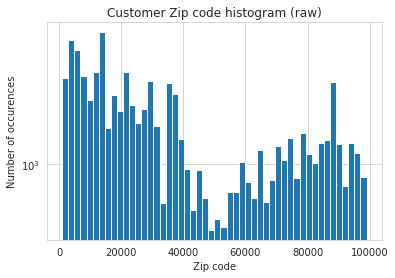

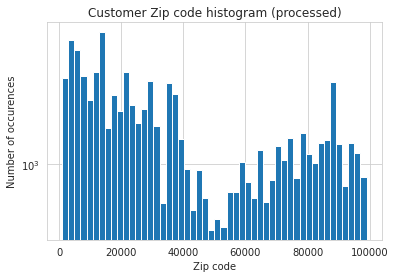

In [322]:
# Section 8 (customer ZIP code)
# print(o_customers.columns)

# For ints only
def generalize_numeric(val, most_significant_digits):
    return int(val / 10**most_significant_digits) * 10**most_significant_digits

for k in range(2, 20):
    if not is_k_anonymous(k, ["customer_zip_code_prefix"], o_customers):
        break
    else:
        print(f"Is {k} anonymous")

# Generalize ZIP code to achieve at least k = 10
zip_backup = o_customers["customer_zip_code_prefix"]
o_customers["customer_zip_code_prefix"] = o_customers["customer_zip_code_prefix"].apply(lambda z: generalize_numeric(z, 3))
achieved_k = 1
for k in range(2, 100):
    if not is_k_anonymous(k, ["customer_zip_code_prefix"], o_customers):
        achieved_k = k - 1
        break
    else:
        print(f"Is {k} anonymous")

histogram(zip_backup, "Customer Zip code histogram (raw)", xlabel="Zip code", bins=50)
histogram(o_customers["customer_zip_code_prefix"], "Customer Zip code histogram (processed)", xlabel="Zip code", bins=50)


In [ ]:
# Section 9 (product prices)

In [ ]:
# Section 10 (delivery dates)